## Triangulation! 

In [21]:
%matplotlib inline
import numpy
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch
from matplotlib.path import Path

In [55]:
simple_square = numpy.array([[0, 0], [0, 1], [1, 1], [1, 0]])

In [56]:
def make_polygon(polygon, holes=None):
    compound_polygon = polygon.copy()
    move_list = [Path.MOVETO] + [Path.LINETO for _ in range(len(polygon) - 2)] + [Path.CLOSEPOLY]
    
    for hole in holes:
        move_list += [Path.MOVETO] + [Path.LINETO for _ in range(len(hole) - 2)] + [Path.CLOSEPOLY]
        compound_polygon = numpy.vstack((compound_polygon, hole))
    
    print(compound_polygon.shape)
    print(len(move_list))
    path = Path(compound_polygon, move_list)
    return path

(12, 2)
12


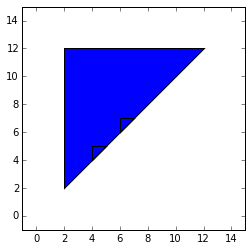

In [57]:
fig = plt.figure(num=1, figsize=(4, 4), dpi=180)
ax = fig.add_subplot(111)

path = make_polygon(simple_square * 10 + 2, holes=[simple_square + 4, simple_square + 6])
patch = PathPatch(path)

ax.add_patch(patch)

ax.set_xlim(-1, 15)
ax.set_ylim(-1, 15)
ax.set_aspect(1.0)

plt.show()

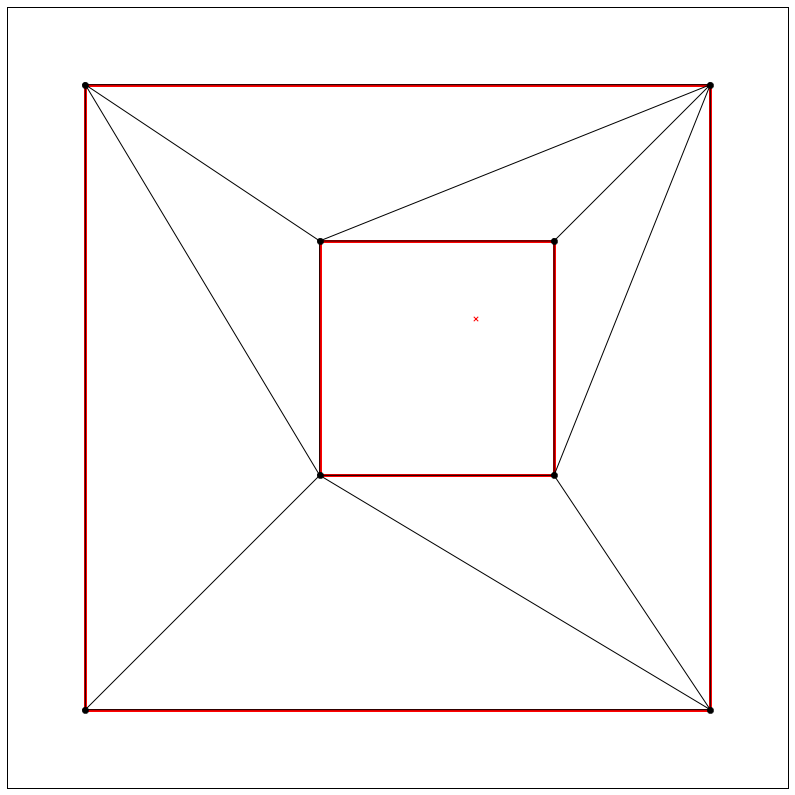

In [87]:
from triangle import triangulate, get_data, plot as tplot
from pprint import pprint

vertices = numpy.vstack((simple_square * 10 + 2, simple_square * 2 + 4))

cndt = triangulate({'vertices': [[2, 2], [2, 10], [10, 10], [10, 2], [5, 5], [5, 8], [8, 8], [8, 5]],
                    'segments': [[0, 1], [1, 2], [2, 3], [3, 0], [4, 5], [5, 6], [6, 7], [7, 4]], 
                    'holes': [[7, 7]]}, 'p')
plt.figure(figsize=(14, 14))
ax = plt.subplot(111, aspect='equal')
tplot.plot(ax, **cndt)
plt.show()